# Train Content Classifier

**Instructions:**
1. Upload `phishing_dataset.csv` when prompted
2. Run all cells
3. Download trained models at the end

**Model:** Logistic Regression + TF-IDF

In [3]:
# Install compatible versions (copy-paste this)
!pip install numpy==1.26.4 scikit-learn==1.4.2 nltk==3.8.1 pandas==2.2.2 matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
def clean_text(text):
    """Clean and preprocess email text"""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

print("✓ Text cleaning function ready!")

✓ Text cleaning function ready!


In [3]:
data_file = "/content/phishing_dataset.csv"
# Load dataset
df = pd.read_csv(data_file)

# Standardize column names and labels
if 'Category' in df.columns and 'Message' in df.columns:
    df = df.rename(columns={'Category': 'label', 'Message': 'text'})
    # Convert ham/spam to legitimate/phishing
    df['label'] = df['label'].map({'ham': 'legitimate', 'spam': 'phishing'})

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")
print(f"\nSample data:")
df.head()

Dataset shape: (5572, 2)

Class distribution:
label
legitimate    4825
phishing       747
Name: count, dtype: int64

Sample data:


,label,text
0,legitimate,"Go until jurong point, crazy.. Available only ..."
1,legitimate,Ok lar... Joking wif u oni...
2,phishing,Free entry in 2 a wkly comp to win FA Cup fina...
3,legitimate,U dun say so early hor... U c already then say...
4,legitimate,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print("Cleaning text... (this may take a minute)")
df['cleaned_text'] = df['text'].apply(clean_text)
print("✓ Text cleaning complete!")

print("\nBefore vs After cleaning:")
df[['text', 'cleaned_text', 'label']].head(3)

Cleaning text... (this may take a minute)
✓ Text cleaning complete!

Before vs After cleaning:


,text,cleaned_text,label
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,legitimate
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni,legitimate
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...,phishing


In [5]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nTraining set distribution:\n{y_train.value_counts()}")

Training samples: 4457
Test samples: 1115

Training set distribution:
label
legitimate    3859
phishing       598
Name: count, dtype: int64


In [6]:
print("Creating TF-IDF features...")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"✓ Feature matrix shape: {X_train_vec.shape}")
print(f"✓ Using {len(vectorizer.get_feature_names_out())} features")

Creating TF-IDF features...
✓ Feature matrix shape: (4457, 5000)
✓ Using 5000 features


In [7]:
print("Training Logistic Regression model...")
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model.fit(X_train_vec, y_train)
print("✓ Training complete!")

Training Logistic Regression model...
✓ Training complete!


In [8]:
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"="*50)
print(f"ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"="*50)
print(f"\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))

ACCURACY: 0.9695 (96.95%)

Detailed Classification Report:

              precision    recall  f1-score   support

  legitimate       0.97      1.00      0.98       966
    phishing       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



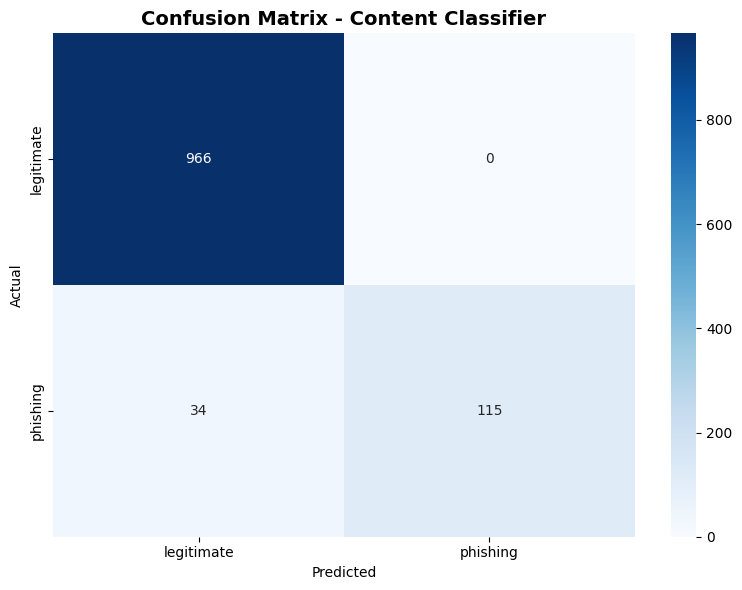


Confusion Matrix Stats:
True Negatives:  966
False Positives: 0
False Negatives: 34
True Positives:  115


In [9]:
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Content Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Print stats
tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
print(f"\nConfusion Matrix Stats:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

In [10]:
# Save models to files
with open('content_classifier_basic.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('content_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("✓ Models saved!")

✓ Models saved!


In [11]:
# Test with sample emails
test_samples = [
    "URGENT! Your account has been suspended. Verify now at http://malicious.com or lose access forever!",
    "Hey, can you send me the project report by tomorrow? Thanks!",
    "Congratulations! You have won a lottery of $1,000,000. Click here to claim immediately!",
    "Meeting scheduled for 3 PM in conference room. Please bring the documents."
]

print("Testing model with sample emails:\n")
print("="*70)
for idx, email in enumerate(test_samples, 1):
    cleaned = clean_text(email)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    probability = model.predict_proba(vectorized)[0]
    confidence = max(probability)

    print(f"\n{idx}. Email: {email[:65]}...")
    print(f"   Prediction: {prediction.upper()}")
    print(f"   Confidence: {confidence:.2%}")
    print("-"*70)

Testing model with sample emails:


1. Email: URGENT! Your account has been suspended. Verify now at http://mal...
   Prediction: LEGITIMATE
   Confidence: 78.20%
----------------------------------------------------------------------

2. Email: Hey, can you send me the project report by tomorrow? Thanks!...
   Prediction: LEGITIMATE
   Confidence: 94.99%
----------------------------------------------------------------------

3. Email: Congratulations! You have won a lottery of $1,000,000. Click here...
   Prediction: LEGITIMATE
   Confidence: 57.07%
----------------------------------------------------------------------

4. Email: Meeting scheduled for 3 PM in conference room. Please bring the d...
   Prediction: LEGITIMATE
   Confidence: 93.68%
----------------------------------------------------------------------
